# Compare BedSmells results

Make sure to run the benchmarks of the notebook `run-benchmarks` before running this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
import seaborn as sns

In [2]:
def load_results(directory: str, tests: list[str]):
    """
    Loads the results of benchmarks for each given provided test

    Args:
        directory(str): Path of results
        tests(str): The tests to load
    """
    results = {}
    if not os.path.exists(directory):
        return results
    
    for attack in os.listdir(directory):
        attack_dir = os.path.join(directory, attack, "tests")
        if not os.path.exists(attack_dir):
            continue
        
        results[attack] = {}
        for test in tests:
            test_file = next((f for f in os.listdir(attack_dir) if test in f), None)
            if test_file:
                with open(os.path.join(attack_dir, test_file), "r") as f:
                    parsed_json = json.load(f)
                    
                    if test == "CompleteTest":
                        results[attack] = parsed_json["CompleteTest"]
                    else:
                        results[attack][test] = parsed_json
    return results

In [3]:
base_dir = "results/CIC17"
improved_dir = "results/CIC17_improved"
tests = ["CosineTest", "NearestNeighboursTest", "PortTest", "SingleFeatureEfficacyTest"]

base_results = [
    load_results('results/CIC17_base_first_run', ["CompleteTest"]),
]

improved_results = [
    load_results('results/CIC17_improved_first_run', ["CompleteTest"]),
    load_results('results/CIC17_improved_second_run', ["CompleteTest"]),
    load_results('results/CIC17_improved_third_run', ["CompleteTest"])
]

In [4]:
improved_results[0]['Port Scan']

{'CosineTest': {},
 'MislabelPortsTest': {'MislabelPorts': 0, 'MislabelPortsPercent': 0.0},
 'MislabelTest': 'Error!',
 'SingleFeatureEfficacy': {'F1Scores': {'id': 1.0,
   'Flow Duration': 1.0,
   'Total Length of Bwd Packet': 1.0,
   'Flow Bytes/s': 1.0,
   'Flow IAT Mean': 1.0,
   'Flow IAT Std': 1.0,
   'Flow IAT Min': 1.0,
   'Fwd IAT Total': 1.0,
   'Fwd IAT Mean': 1.0,
   'Fwd IAT Std': 1.0,
   'Fwd IAT Max': 1.0,
   'Fwd IAT Min': 1.0,
   'Bwd IAT Total': 1.0,
   'Bwd IAT Mean': 1.0,
   'Bwd IAT Std': 1.0,
   'Bwd IAT Min': 1.0,
   'Fwd URG Flags': 1.0,
   'Bwd URG Flags': 1.0,
   'URG Flag Count': 1.0,
   'ECE Flag Count': 1.0,
   'Fwd Bytes/Bulk Avg': 1.0,
   'Fwd Bulk Rate Avg': 1.0,
   'Bwd Bytes/Bulk Avg': 1.0,
   'Bwd Bulk Rate Avg': 1.0,
   'Subflow Bwd Packets': 1.0,
   'Active Mean': 1.0,
   'Active Std': 1.0,
   'Active Max': 1.0,
   'Active Min': 1.0,
   'Idle Mean': 1.0,
   'Idle Std': 1.0,
   'Idle Max': 1.0,
   'Idle Min': 1.0,
   'Total TCP Flow Time': 1.0,
   'F

Let's now compare them for each metric shown in the paper ["DataBadSmells"](https://github.com/DataBadSmells/DataBadSmells)

In [5]:
def calculate_heuristics(test_results: dict) -> dict:
    """
    Extracts heuristic values (PDDC, TCC, HDFC, UGTC, WLC) from the given test results.
    
    Parameters:
        test_results (dict): Dictionary containing test results for a given attack class.

    Returns:
        dict: Dictionary with calculated heuristic values.
    """
    heuristics = {}
    
    # Extracting values from test results
    cosine_test = test_results.get('CosineTest', {})
    mislabel_ports_test = test_results.get('MislabelPortsTest', {})
    mislabel_test = test_results.get('MislabelTest', None)
    single_feature_efficacy = test_results.get('SingleFeatureEfficacy', {}).get('F1Scores', {})
    
    # PDDC: Poor Data Diversity (Largest Cluster Percentage)
    pddc = cosine_test.get('Largest Cluster Percentage', None)
    
    # TCC: Traffic Collapse (Percentage of flows with Cosine Similarity > 0.95)
    cutoff_percentages = cosine_test.get('Cutoff Percentages', {})
    tcc = max(cutoff_percentages.values(), default=None) if isinstance(cutoff_percentages, dict) else None
    
    # HDFC: Highly Dependent Features (Maximum F1-score from Single Feature Efficacy test)
    hdfc = max(single_feature_efficacy.values(), default=None) if single_feature_efficacy else None
    
    # UGTC: Unclear Ground Truth (Mislabel Ports Percentage)
    ugtc = mislabel_ports_test.get('MislabelPortsPercent', None)
    
    # WLC: Wrong Label Count (Mislabel Percentage or error flag)
    wlc = mislabel_test.get('Percentage', None) if isinstance(mislabel_test, dict) else None
    
    heuristics['PDDC'] = pddc
    heuristics['TCC'] = tcc
    heuristics['HDFC'] = hdfc
    heuristics['UGTC'] = ugtc
    heuristics['WLC'] = wlc
    
    return heuristics

In [6]:
paper_reported_base_dataset_heuristics = {
    "Port Scan": {"PDDC": 0.99, "TCC": 0.99, "WLC": 0.0, "HDFC": 0.98, "UGTC": 0.0},
    "DoS Hulk": {"PDDC": 0.98, "TCC": 0.98, "WLC": 0.0, "HDFC": 1.0, "UGTC": 0.0},
    "FTP Patator": {"PDDC": 0.98, "TCC": 0.98, "WLC": 0.0, "HDFC": 0.99, "UGTC": 0.0},
    "SSH Patator": {"PDDC": 1.0, "TCC": 1.0, "WLC": 0.0, "HDFC": 0.98, "UGTC": 0.0},
    "DDoS": {"PDDC": 0.98, "TCC": 0.94, "WLC": 0.0, "HDFC": 0.99, "UGTC": 0.0},
    "Bot": {"PDDC": 0.98, "TCC": 1.0, "WLC": 0.01, "HDFC": 1.0, "UGTC": 0.0},
    "DoS slowloris": {"PDDC": 0.97, "TCC": 1.0, "WLC": 0.0, "HDFC": 0.98, "UGTC": 0.0},
    "DoS Slowhttptest": {"PDDC": 0.88, "TCC": 0.53, "WLC": 0.0, "HDFC": 0.96, "UGTC": 0.0},
    "DoS GoldenEye": {"PDDC": 0.95, "TCC": 0.68, "WLC": 0.0, "HDFC": 1.0, "UGTC": 0.0},
    "Infiltration": {"PDDC": 0.92, "TCC": 0.65, "WLC": 0.81, "HDFC": 0.75, "UGTC": 0.0},
    "Web Attack - Brute Force": {"PDDC": 0.99, "TCC": 0.93, "WLC": 0.06, "HDFC": 0.91, "UGTC": 0.0},
    "XSS": {"PDDC": 0.78, "TCC": 0.48, "WLC": 0.35, "HDFC": 0.93, "UGTC": 0.0},
    "Web Attack - Sql Injection": {"PDDC": None, "TCC": None, "WLC": 0.63, "HDFC": None, "UGTC": 0.0},
    "Heartbleed": {"PDDC": None, "TCC": None, "WLC": 0.18, "HDFC": None, "UGTC": 0.0},
}

In [13]:
metrics = ["PDDC", "TCC", "WLC", "HDFC"]
formatted_metrics = []

for metric in metrics:
    formatted_metrics.append(f"{metric} (base paper)")
    # formatted_metrics.append(f"{metric} (base calculated)")
    for i, _ in enumerate(improved_results):
        formatted_metrics.append(f"{metric} (improved #{i})")

# prepare results list with alternating base and improved values
data = []
attacks = list(improved_results[0].keys())
base_heuristics = [{attack: calculate_heuristics(result[attack]) for attack in result} for result in base_results]
improved_heuristics = [{attack: calculate_heuristics(result[attack]) for attack in result} for result in improved_results]

for attack in attacks:
    row = [attack]
    for metric in metrics:
        row.append(paper_reported_base_dataset_heuristics[attack][metric])

        # for h in base_heuristics:
        #    if h[attack][metric]:
        #        row.append(f"{h[attack][metric]:.2f}")
        #    else:
        #        row.append("NaN")
        
        for h in improved_heuristics:
            if h[attack][metric]:
                row.append(f"{h[attack][metric]:.2f}")
            else:
                row.append("NaN")
    data.append(row)

df = pd.DataFrame(data, columns=["Attack"] + formatted_metrics)

df

,Attack,PDDC (base paper),PDDC (improved #0),PDDC (improved #1),PDDC (improved #2),TCC (base paper),TCC (improved #0),TCC (improved #1),TCC (improved #2),WLC (base paper),WLC (improved #0),WLC (improved #1),WLC (improved #2),HDFC (base paper),HDFC (improved #0),HDFC (improved #1),HDFC (improved #2)
0,SSH Patator,1.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.98,1.00,1.00,1.00
1,DoS Hulk,0.98,0.70,0.71,0.70,0.98,0.78,0.74,0.76,0.00,0.00,0.01,0.00,1.00,1.00,1.00,1.00
2,DDoS,0.98,0.51,0.51,0.50,0.94,0.48,0.47,0.46,0.00,0.00,0.00,0.00,0.99,1.00,1.00,1.00
3,DoS slowloris,0.97,NaN,NaN,NaN,1.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.98,1.00,1.00,1.00
4,Heartbleed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18,1.00,1.00,1.00,NaN,1.00,1.00,1.00
5,DoS Slowhttptest,0.88,0.57,0.56,0.58,0.53,0.68,0.70,0.68,0.00,1.00,1.00,1.00,0.96,0.95,0.95,0.95
6,Port Scan,0.99,NaN,NaN,NaN,0.99,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.98,1.00,1.00,1.00
7,FTP Patator,0.98,NaN,NaN,NaN,0.98,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.99,1.00,1.00,1.00
8,Bot,0.98,NaN,NaN,NaN,1.00,NaN,NaN,NaN,0.01,NaN,NaN,NaN,1.00,1.00,1.00,1.00
9,Web Attack - Sql Injection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,NaN,NaN,1.00,1.00,1.00


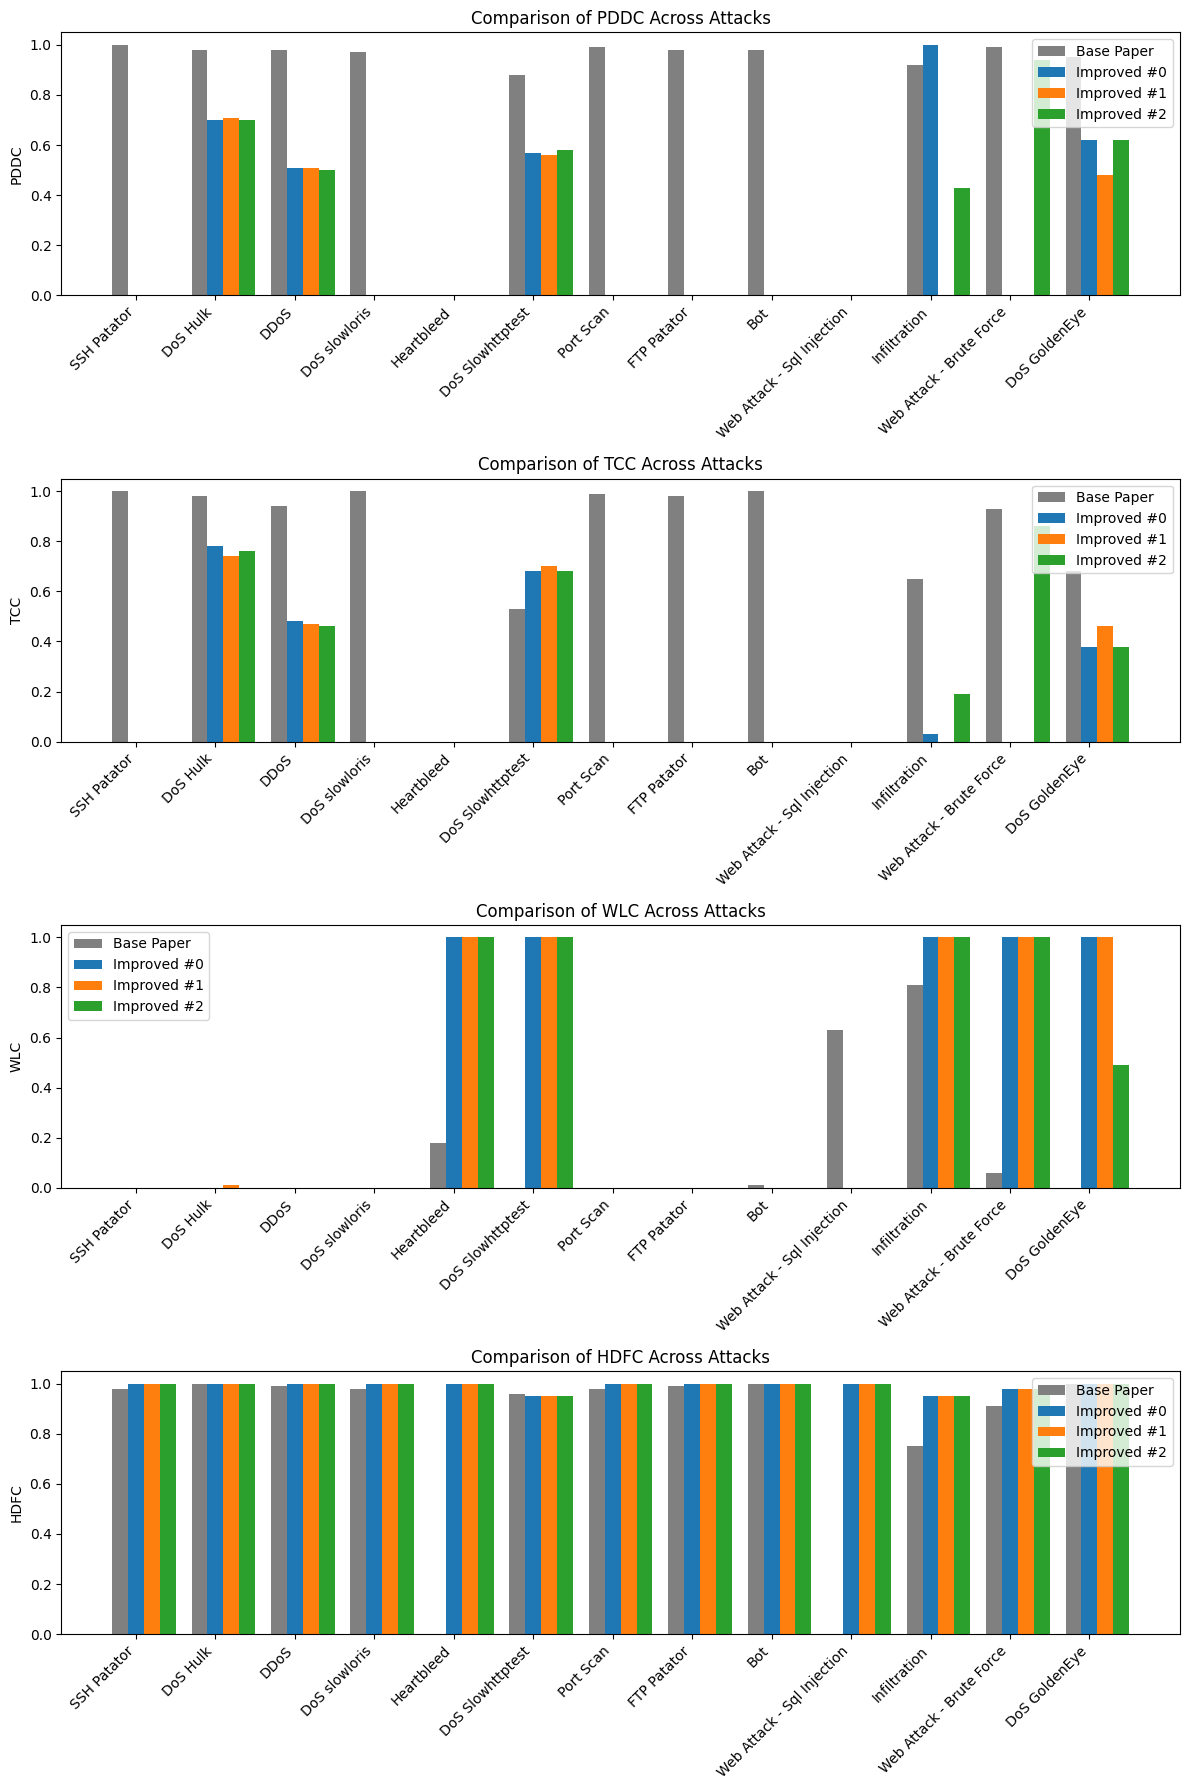

In [10]:
# plot results
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 18))

for i, metric in enumerate(metrics):
    ax = axes[i]
    attack_labels = df["Attack"]
    
    base_paper_values = df[f"{metric} (base paper)"].astype(float)
    improved_values = [df[f"{metric} (improved #{j})"].astype(float) for j in range(len(improved_results))]

    width = 0.2
    x = np.arange(len(attack_labels))

    ax.bar(x - width, base_paper_values, width=width, label="Base Paper", color="gray")

    for j, values in enumerate(improved_values):
        ax.bar(x + (j * width), values, width=width, label=f"Improved #{j}")

    ax.set_xticks(x)
    ax.set_xticklabels(attack_labels, rotation=45, ha="right")
    ax.set_ylabel(metric)
    ax.set_title(f"Comparison of {metric} Across Attacks")
    ax.legend()

plt.tight_layout()
plt.show()